In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('seaborn-pastel')
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data = pd.read_csv('/kaggle/input/loandata/Loan payments data.csv')

In [ ]:
print(data.shape)
data.head()

In [ ]:
data['loan_status'].unique()

- 'Paidoff' = 기한 내 대출금 모두 상환
- 'collection' = 연체
- 'collection paidoff' = 기한 지나서 모두 상환

# data description

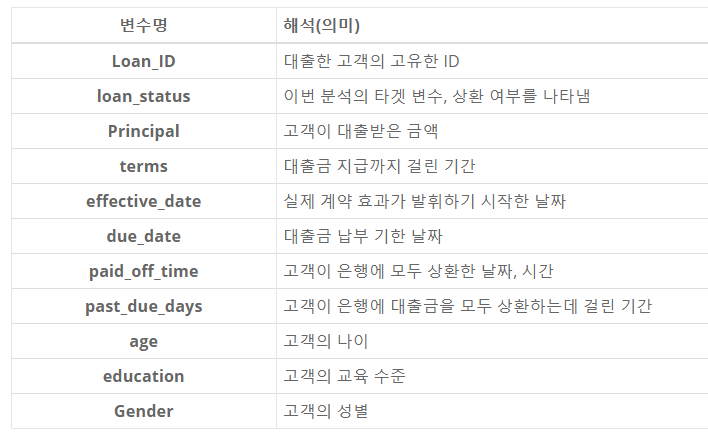

# EDA

In [ ]:
import missingno as msno
msno.bar(data)

In [ ]:
data[['paid_off_time','past_due_days']].isnull().sum()

In [ ]:
data[(data['paid_off_time'].isnull()) & (data['loan_status'] != 'COLLECTION')]

In [ ]:
data[data['past_due_days'].isnull() & (data['loan_status'] != 'PAIDOFF')]

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
sns.countplot(data['Gender'],ax=ax1)
sns.countplot(data['Gender'],hue=data['loan_status'],ax=ax2)

for p in ax1.patches:   
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize=10)
for p in ax2.patches:   
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize=10) 

Overall, it can be seen that the man had a lot of loans.

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data['education'],ax=ax1)
sns.countplot(data['education'],hue= data['loan_status'],ax=ax2)
ax1.tick_params(labelrotation=30)
ax2.tick_params(labelrotation=30)
plt.legend(loc='best')
for p in ax1.patches:   
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize=10)
for p in ax2.patches:   
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize=10) 

In [ ]:
data[['loan_status', 'education', 'Loan_ID']].groupby(['loan_status', 'education']).agg(['count'])

In [ ]:
plt.figure(figsize=(12,8))
sns.catplot(data=data,x='loan_status',y='Principal',col='Gender',hue='education',kind='bar',ci=False)

- The characteristic of delinquent borrowers is that they borrow a lot of money.
- Among them, the man with the highest level of education, Master or Above, borrowed the most money and delayed the payment. However, we must be careful not to make the fallacy of hasty generalization as it is a minority.


In [ ]:
data['age'].describe()

In [ ]:
data['age_range'] = pd.cut(data['age'],[10,20,30,40,50,60],labels=['10s','20s','30s','40s','50s'])

In [ ]:
plt.figure(figsize=(12,8))
ax=sns.countplot(data['age_range'],hue=data['loan_status'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center",fontsize=10)

In [ ]:
data[['loan_status', 'age_range', 'Loan_ID']].groupby(['loan_status', 'age_range']).agg(['count'])

In [ ]:
sns.boxplot(x=data['loan_status'],y=data['Principal'])

- Most of the defaulters borrowed high loans.

In [ ]:
data[['loan_status', 'Principal', 'Loan_ID']].groupby(['loan_status', 'Principal']).agg(['count'])

# Preprocessing

In [ ]:
import datetime
data['effective_date']=data['effective_date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y'))
data['due_date']=data['due_date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y'))

In [ ]:
data['paid_off_time'] = data['paid_off_time'].apply(lambda x: datetime.datetime.strptime(x,'%m/%d/%Y %H:%M') if type(x) == str else x)

In [ ]:
data.head()

####  replace missing values

- The column in past_due_days is treated as missing because it is not overdue.
- Therefore, the missing values are replaced by the due date paid minus the date of data creation.
- The data creation date is the date past_due_days is added to the value of missing values by due_days.

In [ ]:
# proof
from datetime import timedelta
print(data['due_date'][300] + timedelta(days = data['past_due_days'][300]))
print(data['due_date'][301] + timedelta(days = data['past_due_days'][301]))

Missing values of paid_off_time are replaced by 2016-12-08.

In [ ]:
na_idx = data[data['paid_off_time'].isnull()].index
for i in na_idx:
    data['paid_off_time'].iloc[i] = data['due_date'][i] + timedelta(days = data['past_due_days'][i])

In [ ]:
data.head()

In [ ]:
data['paid_off_time'] = data['paid_off_time'].apply(lambda x: '{}-{}-{}'.format(x.year,x.month,x.day))

In [ ]:
data['paid_off_time'] = data['paid_off_time'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d'))

In [ ]:
idx = data[data['past_due_days'].isnull()].index
data['past_due_days'][idx] = data['paid_off_time'][idx] - data['due_date'][idx]

In [ ]:
msno.bar(data)

We have dealt with all the missing values.

In [ ]:
try:
    for i in range(len(data['past_due_days'])):
        data['past_due_days'][i] = data['past_due_days'][i].days
except:
    pass

In [ ]:
data['loan_status'].unique()

In [ ]:
data[data['loan_status'] == 'COLLECTION']

I found something strange while looking at the data.

In some cases, it was against the formula 'due_date'-'effective_date' = term.

Let's see the index number 398.

According to the formula, it should be 60 but 'term' is 30.

So I assumed that there were times when the period was extended.

However, if there is only one case, it will be judged as a data error.

In [ ]:
data['tmp']=data['due_date'] - data['effective_date'] + timedelta(days=1)
data['tmp'] = data['tmp'].dt.days

In [ ]:
extension_idx = []
for i in range(data.shape[0]):
    if data['terms'][i] < data['tmp'][i]:
        extension_idx.append(i)
    else:
        continue
data.iloc[extension_idx]

Therefore, I will create a new column called 'extension'.

In [ ]:
extension_idx = []
for i in range(data.shape[0]):
    if data['terms'][i] < data['tmp'][i]:
        data['tmp'][i] = 'Y'
    else:
        data['tmp'][i] = 'N'

In [ ]:
data.rename(columns={'tmp':'extension'},inplace=True)

In [ ]:
data.head()

Variable conversion is easy to model

In [ ]:
data['loan_status'].unique()

In [ ]:
loan_dic = {'PAIDOFF':0,'COLLECTION_PAIDOFF':1,'COLLECTION':2}
data['loan_status'] = data['loan_status'].map(loan_dic)

Delete variables of type datetime.

This is because the datetime format is not only applicable to the model, but has already obtained a new derived variable that can be obtained from this variable.

And the age variable is deleted because there is an age_range variable.

In [ ]:
data.drop(['effective_date','due_date','paid_off_time','age'],axis=1,inplace=True)

The category type is converted to OneHotEncoding.

In [ ]:
data.info()

In [ ]:
data['past_due_days'] = data['past_due_days'].astype(float)

In [ ]:
category_features = ['education','Gender','age_range','extension']
for i in category_features:
    data[i] = data[i].astype('category')

In [ ]:
id_ = data['Loan_ID']
data = pd.get_dummies(data.drop(['Loan_ID'],axis=1))

In [ ]:
data

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size=.2)
print("train shape:{}\ntest shape:{}".format(train.shape,test.shape))

In [ ]:
train = train.reset_index(drop=True)
train_x = train.drop('loan_status',axis=1)
train_y = train['loan_status']
test = test.reset_index(drop=True)
test_x = test.drop('loan_status',axis=1)
test_y = test['loan_status']

# Modeling

- Ensemble and xgboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
rf=RandomForestClassifier()
ada=AdaBoostClassifier()
gra = GradientBoostingClassifier()
xgb = XGBClassifier()

In [ ]:
rf.fit(train_x,train_y)
pred = rf.predict(test_x)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y.values,pred)

In [ ]:
score_df=pd.DataFrame(columns=['model','score'])
idx=0
for i in [rf,ada,gra,xgb]:
    i.fit(train_x,train_y)
    pred = i.predict(test_x)
    score_df.loc[idx,'model'] = i.__class__.__name__
    score_df.loc[idx,'score'] = accuracy_score(test_y.values,pred)
    idx+=1
score_df

In [ ]:
plt.figure(figsize=(12,8))
ax= sns.barplot(data=score_df,x='model',y='score')
plt.ylim(0,1.1)
for p in ax.patches:   
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height,height ,ha="center",fontsize=13)
plt.title('score by model')

In [ ]:
fig,axes = plt.subplots(4,1,figsize=(10,8))
num=0
for i in [rf,ada,gra,xgb]:
    
    feat_importances = pd.Series(i.feature_importances_, index=train_x.columns)
    feat_importances.nlargest(5).plot(kind='barh',ax=axes[num])

    
    axes[num].set(title='{} featrue importances'.format(i.__class__.__name__))
    plt.tight_layout()
    num+=1


'past_due_days' most affected the accuracy of the model.

- nerual network by pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

Range (range) between '0 to 1'manually with minimum (minimum) and maximum (maximum) values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_x_scale = minmax.fit_transform(train_x)
test_x_scale = minmax.fit_transform(test_x)

In [ ]:
trainx_tensor = torch.tensor(train_x_scale,dtype=torch.float)
trainy_tensor = torch.tensor(train_y.values,dtype = torch.float)

testx_tensor = torch.tensor(test_x_scale,dtype = torch.float)
testy_tensor = torch.tensor(test_y.values,dtype = torch.float)

trainx_tensor = trainx_tensor.type(torch.FloatTensor)
trainy_tensor = trainy_tensor.type(torch.LongTensor)

testx_tensor = testx_tensor.type(torch.FloatTensor)
testy_tensor = testy_tensor.type(torch.LongTensor)

In [ ]:
num_epoch = 10000
learning_rate = 0.0002
loss_func = nn.CrossEntropyLoss()
w = data.shape[1]-1  # number of input's values

In [ ]:
def model_RRRLR():
    model = nn.Sequential(
          nn.Linear(1*w,6*w), nn.ReLU(),
          nn.Linear(6*w,10*w), nn.ReLU(),
          nn.Linear(10*w,6*w), nn.ReLU(),
          nn.Linear(6*w,1*w), nn.LeakyReLU(),
          nn.Linear(w,3) )
    return model

In [ ]:

loss_array = []
model = model_RRRLR()
optimizer = optim.Adam(model.parameters(),learning_rate)

for i in range(num_epoch):
    optimizer.zero_grad()
    output = model(trainx_tensor)
    loss = loss_func(output,trainy_tensor)
    if i%5000==0:
        print(loss)
    loss.backward()
    optimizer.step()
    loss_array.append(loss)
plt.plot(loss_array)
plt.title('RRRLR loss array')

In [ ]:
output = model(testx_tensor)
result = []
for i in output:
    if i.argmax() == 2:
        result.append(2)
    elif i.argmax() == 1:
        result.append(1)
    else:
        result.append(0)


In [ ]:
accuracy_score(test_y.values,result)

# limitation

The small size of the sample increased the risk of overfit.

# improvement point

Use cross-validation to test your predictive power.